### **Definir el directorio de trabajo con Google Colab**
Define el directorio de trabajo como la carpeta `working_directory` de la carpeta compartida `DS4A-Team12` de Drive.

In [1]:
import os
from google.colab import drive 
# Enlazar a la carpeta data de la carpeta compartida en Drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/DS4A-Team12/data'
os.chdir(working_dir)
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgYqHMuO0NPGkxXWKl1Wh9E9HsOg7ZI4aYPssDMyoDBDGC2CSTApts
Mounted at /content/drive
/content/drive/MyDrive/DS4A-Team12/data


In [2]:
# Librerias relevantes
import time
import pandas as pd
import numpy as np
import json
import re
import joblib

### **Abrir base de datos de tomas nutricionales del ICBF (Dirección de Primera Infancia)**
Abre las primeras 98 columnas de todos los registros de la base de datos, preprocesados para asignarle a cada variable el tipo de dato correspondiente (archivo `TomasDPIpre.parquet` de 472.4 MB) como un dataframe de nombre `tom`.
Para preprocesar un archivo ir a [`Preprocesamiento_Tomas_.ipynb`](https://https://colab.research.google.com/drive/1ztyI5yfqs6LY7LOYXHr0q4WCrDdfotBs#scrollTo=KJM1uKZq71HA).

In [3]:
time0 = time.time()
# Abre el diccionario con la estructura de datos definida para ambos datasets
#with open('datatypes_dictionaries/dtypes_vars_toma.json', 'r') as file:
 # dtypes_vars_toma = json.load(file)
#with open('datatypes_dictionaries/dtypes_sociodemo.json', 'r') as file:
 # dtypes_soc = json.load(file)
# Lee el archivo marcado
tom = pd.read_parquet('preprocessed_data/join_sociodemo_tomas_tagged.parquet')
#tom = tom.astype(dtypes_vars_toma)
tom.info()

geo = pd.read_csv('auxiliary_data/municipio_poblacion_sexo_edad_pib.csv')
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206532 entries, 0 to 1206531
Data columns (total 71 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Cod_clase                  1206532 non-null  int64         
 1   Ind_grupo_sisben_4         1206532 non-null  category      
 2   Ind_nivel_sisben_4         1206532 non-null  int64         
 3   Tip_vivienda               1206532 non-null  int64         
 4   Ind_tiene_energia          1206532 non-null  int64         
 5   Ind_tiene_alcantarillado   1206532 non-null  int64         
 6   Ind_tiene_gas              1206532 non-null  int64         
 7   Ind_tiene_recoleccion      1206532 non-null  int64         
 8   Ind_tiene_acueducto        1206532 non-null  int64         
 9   n_hogares_vivienda         1206532 non-null  UInt8         
 10  Tip_ocupa_vivienda         1206532 non-null  int64         
 11  Ind_tiene_cocina           1206532 no

In [4]:
tom.cod_mpio.nunique(), geo.DPMP.nunique()

(1050, 1122)

In [5]:
geo.head()

,Unnamed: 0,DP,DPNOM,DPMP,MPIO,AÑO,Hombres_0,Hombres_1,Hombres_2,Hombres_3,Hombres_4,Hombres_5,Mujeres_0,Mujeres_1,Mujeres_2,Mujeres_3,Mujeres_4,Mujeres_5,Total Hombres,Total Mujeres,Total,PIB
0,0,5,Antioquia,5001,Medellín,2018,14474,14600,14699,14782,14861,14942,13828,13973,14097,14204,14309,14415,1140658,1286471,2427129,55082.301180
1,1,5,Antioquia,5001,Medellín,2019,14863,14902,14984,15040,15081,15122,14220,14244,14345,14428,14494,14559,1168926,1314619,2483545,59974.806184
2,2,5,Antioquia,5002,Abejorral,2018,132,130,129,132,136,141,136,132,132,134,135,137,10534,9833,20367,231.172055
3,3,5,Antioquia,5002,Abejorral,2019,130,128,129,131,134,139,131,130,130,131,132,135,10510,9748,20258,257.196344
4,4,5,Antioquia,5004,Abriaquí,2018,24,23,23,24,22,23,19,20,20,19,20,20,1452,1243,2695,28.562662


In [6]:
geo[['DPMP', 'MPIO']].drop_duplicates().sort_values('DPMP')

,DPMP,MPIO
0,5001,Medellín
2,5002,Abejorral
4,5004,Abriaquí
6,5021,Alejandría
8,5030,Amagá
...,...,...
2234,97889,Yavaraté (CD)
2236,99001,Puerto Carreño
2238,99524,La Primavera
2240,99624,Santa Rosalía


In [7]:
mpio_n_beneficiarios = tom.groupby('cod_mpio')['IdBeneficiario'].\
  count().reset_index().rename(columns={'IdBeneficiario': 'n_beneficiarios'})
mpio_n_beneficiarios.head()

,cod_mpio,n_beneficiarios
0,5001,47673
1,5002,715
2,5004,121
3,5021,275
4,5030,891


In [8]:
mpio_incidencia = tom.groupby('cod_mpio')['desnutricion', 'recuperacion', 'reincidencia'].\
  sum().reset_index()
mpio_incidencia.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,cod_mpio,desnutricion,recuperacion,reincidencia
0,5001,1111,1004,117
1,5002,17,16,0
2,5004,0,0,0
3,5021,0,0,0
4,5030,20,19,3


In [9]:
mpio_porcentajes = mpio_n_beneficiarios.merge(mpio_incidencia, on='cod_mpio', how='inner')
mpio_porcentajes.head()

,cod_mpio,n_beneficiarios,desnutricion,recuperacion,reincidencia
0,5001,47673,1111,1004,117
1,5002,715,17,16,0
2,5004,121,0,0,0
3,5021,275,0,0,0
4,5030,891,20,19,3


In [10]:
for col_index in range(3):
  col_num = mpio_porcentajes.columns[col_index + 2]
  col_denum = mpio_porcentajes.columns[col_index + 1]
  mpio_porcentajes[f'fracc_{col_num}'] = mpio_porcentajes[col_num] / mpio_porcentajes[col_denum]
mpio_porcentajes.head()

,cod_mpio,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia
0,5001,47673,1111,1004,117,0.023305,0.903690,0.116534
1,5002,715,17,16,0,0.023776,0.941176,0.000000
2,5004,121,0,0,0,0.000000,NaN,NaN
3,5021,275,0,0,0,0.000000,NaN,NaN
4,5030,891,20,19,3,0.022447,0.950000,0.157895


In [11]:
geo2018 = geo.loc[geo['AÑO'] == 2018, ['DPMP', 'MPIO', 'Total', 'PIB']]
geo2018_mpio = geo2018.groupby(['DPMP', 'MPIO'])['Total', 'PIB'].sum().reset_index()
geo2018_mpio.columns = ['cod_mpio', 'mpio', 'poblacion', 'PIB']
geo2018_mpio.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,cod_mpio,mpio,poblacion,PIB
0,5001,Medellín,2427129,55082.301180
1,5002,Abejorral,20367,231.172055
2,5004,Abriaquí,2695,28.562662
3,5021,Alejandría,4657,52.334339
4,5030,Amagá,30227,492.098704


In [12]:
join = geo2018_mpio.merge(mpio_porcentajes, on='cod_mpio', how='inner')
join.head(2)

,cod_mpio,mpio,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia
0,5001,Medellín,2427129,55082.301180,47673,1111,1004,117,0.023305,0.903690,0.116534
1,5002,Abejorral,20367,231.172055,715,17,16,0,0.023776,0.941176,0.000000


In [13]:
for condicion in ['desnutricion', 'recuperacion', 'reincidencia', 'PIB']:
  join[f'{condicion}_per_cap'] = join[condicion] / join['poblacion'] * 1e5
join.head()

,cod_mpio,mpio,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia,desnutricion_per_cap,recuperacion_per_cap,reincidencia_per_cap,PIB_per_cap
0,5001,Medellín,2427129,55082.301180,47673,1111,1004,117,0.023305,0.903690,0.116534,45.774246,41.365745,4.820510,2269.442670
1,5002,Abejorral,20367,231.172055,715,17,16,0,0.023776,0.941176,0.000000,83.468356,78.558452,0.000000,1135.032432
2,5004,Abriaquí,2695,28.562662,121,0,0,0,0.000000,NaN,NaN,0.000000,0.000000,0.000000,1059.839051
3,5021,Alejandría,4657,52.334339,275,0,0,0,0.000000,NaN,NaN,0.000000,0.000000,0.000000,1123.777945
4,5030,Amagá,30227,492.098704,891,20,19,3,0.022447,0.950000,0.157895,66.166011,62.857710,9.924902,1628.010400


In [14]:
join.sort_values('fracc_reincidencia').dropna().tail()

,cod_mpio,mpio,poblacion,PIB,n_beneficiarios,desnutricion,recuperacion,reincidencia,fracc_desnutricion,fracc_recuperacion,fracc_reincidencia,desnutricion_per_cap,recuperacion_per_cap,reincidencia_per_cap,PIB_per_cap
273,15763,Sotaquirá,8162,104.541067,173,3,2,1,0.017341,0.666667,0.5,36.755697,24.503798,12.251899,1280.826594
790,63548,Pijao,5219,138.038969,220,6,6,3,0.027273,1.000000,0.5,114.964553,114.964553,57.482276,2644.931389
584,41378,La Argentina,12866,112.495686,853,3,2,1,0.003517,0.666667,0.5,23.317270,15.544847,7.772423,874.364106
951,73678,San Luis,13553,122.249589,709,2,1,1,0.002821,0.500000,1.0,14.756880,7.378440,7.378440,902.011280
223,15325,Guayatá,3400,58.131847,95,1,1,1,0.010526,1.000000,1.0,29.411765,29.411765,29.411765,1709.760211


reincidencia            0.023707
fracc_desnutricion      0.023861
fracc_recuperacion     -0.058971
fracc_reincidencia     -0.001734
desnutricion_per_cap   -0.059456
recuperacion_per_cap   -0.068736
reincidencia_per_cap   -0.031189
PIB_per_cap             1.000000
Name: PIB_per_cap, dtype: float64

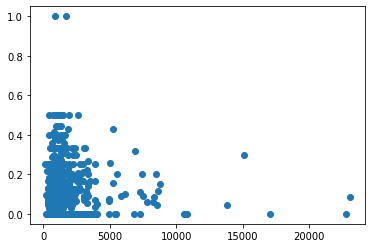

In [15]:
import matplotlib.pyplot as plt
plt.scatter(x=join.PIB_per_cap, y=join.fracc_reincidencia)
join.iloc[:, 7:].corr().loc['PIB_per_cap']

In [16]:
join.to_parquet('preprocessed_data/incidencia_mpio.parquet')

In [17]:
muestras = list()
for cod_mpio in set(tom['cod_mpio']):
  tom_mpio = tom[tom['cod_mpio'] == cod_mpio]
  n_muestra = min(len(tom_mpio), 500)
  muestra_mpio = tom_mpio.sample(n_muestra, random_state=12)
  muestras.append(muestra_mpio)
tom_max_500 = pd.concat(muestras)
tom_max_500

,Cod_clase,Ind_grupo_sisben_4,Ind_nivel_sisben_4,Tip_vivienda,Ind_tiene_energia,Ind_tiene_alcantarillado,Ind_tiene_gas,Ind_tiene_recoleccion,Ind_tiene_acueducto,n_hogares_vivienda,Tip_ocupa_vivienda,Ind_tiene_cocina,Ind_tiene_nevera,Ind_tiene_lavadora,Ind_tiene_pc,Ind_tiene_internet,n_personas_hogar,Sexo,Ind_ninguna_discapac,Tip_seg_social,Ind_acudio_salud,Ind_fue_atendido_salud,Tip_cuidado_ninos,Ind_recibe_comida,Ind_leer_escribir,Ind_estudia,privado_logro_educ,privado_analfabe,privado_inasistencia,privado_rezago,privado_primera_inf,privado_trabajo_inf,privado_desemp_largo,privado_trabajo_info,privado_aseguram,privado_acceso_salud,privado_agua,privado_excreta,privado_suelo,privado_pared,privado_hacina,n_privaciones,IndicadorPobrezaMulti,ingresos_promP_imp,gasto_ppers_imp,gasto_alim_ppers_imp,porc_gasto_alim,union_temprana,n_ninos,Tip_hijo,Jefat_fem,Tip_familia,Genera_ingresos,Nivel_educ_padre,Nivel_educ_madre,anno_encuesta,Uni_dias_agua,Ind_afec_evento_natural,n_afec_evento_natural,Edad_padres_mayor,Edad_padres_menor,Comparte_cocina_sanitario,Estrato,cod_mpio,cod_dpto,FechaNacimiento,IdBeneficiario,Id,desnutricion,recuperacion,reincidencia
814778,2,A,2,1,1,0,0,1,0,1,4,1,0,0,0,0,5,1.0,1,3,1.0,1.0,2,1.0,NaN,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,5.85,1,40000.0,71200.0,60000.0,84.0,0,4,3,1,4,1,NaN,2.0,2018,0.000,0,0,24,24,0,0,18460,18,2014-09-23,11105839,4092237,False,False,False
971327,3,A,4,1,0,0,0,0,0,1,3,1,0,0,0,0,7,0.0,1,3,NaN,NaN,2,1.0,NaN,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,5.55,1,2857.0,79166.0,60000.0,75.0,0,5,3,0,6,3,4.0,2.0,2018,0.000,0,0,33,33,0,0,18460,18,2017-12-28,16217569,4800411,False,False,False
213343,1,D,51,1,1,1,0,1,1,3,2,1,1,1,0,0,3,1.0,1,1,NaN,NaN,4,1.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.60,0,956000.0,281333.0,200000.0,71.0,0,1,2,1,6,4,6.0,6.0,2019,0.875,0,0,34,28,1,1,18460,18,2016-02-14,15635779,1068039,False,False,False
971359,3,A,4,1,1,0,0,0,0,1,3,1,1,0,0,0,7,1.0,1,0,NaN,NaN,2,0.0,NaN,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,4.20,0,35715.0,79166.0,60000.0,75.0,0,4,3,1,6,3,4.0,2.0,2018,0.000,1,2,37,32,0,1,18460,18,2018-09-19,17517485,4800551,True,True,False
971312,3,A,3,1,1,0,0,1,0,1,3,1,0,0,0,0,8,1.0,1,3,NaN,NaN,2,1.0,NaN,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,5.70,1,2.0,23500.0,12500.0,53.0,0,6,3,1,6,3,3.0,2.0,2019,0.000,1,2,39,36,0,1,18460,18,2015-02-04,12767414,4800344,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785016,1,A,2,2,1,1,0,1,1,1,1,1,1,0,0,0,4,0.0,1,3,NaN,NaN,1,1.0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3.00,0,40000.0,77500.0,50000.0,64.0,0,3,3,1,4,1,NaN,4.0,2019,1.750,0,0,27,27,0,1,86001,86,2016-12-10,17582540,3959224,False,False,False
1203119,3,A,1,2,1,0,0,1,0,1,4,1,0,0,0,0,2,1.0,0,3,NaN,NaN,2,1.0,NaN,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,4.80,0,100000.0,55000.0,50000.0,90.0,0,1,2,1,4,1,NaN,3.0,2019,0.000,0,0,21,21,0,1,86001,86,2019-05-31,18503074,5929196,False,False,False
781751,1,A,5,1,1,1,1,1,1,3,4,1,0,0,0,0,4,1.0,1,0,NaN,NaN,9,NaN,0.0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,5.85,1,90000.0,157500.0,142500.0,90.0,0,2,3,0,6,3,3.0,3.0,2019,0.375,0,0,48,36,1,1,86001,86,2012-09-21,12718301,3943267,False,False,False
787557,1,B,7,1,1,1,1,1,1,2,4,1,0,0,0,0,4,1.0,1,3,NaN,NaN,9,NaN,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.60,0,272502.0,76250.0,50000.0,65.0,0,2,1,0,6,3,4.0,4.0,2019,4.000,0,0,29,23,1,1,86001,86,2014-06-01,14313295,3971592,False,False,False


In [18]:
tom_max_500.columns

Index(['Cod_clase', 'Ind_grupo_sisben_4', 'Ind_nivel_sisben_4', 'Tip_vivienda',
       'Ind_tiene_energia', 'Ind_tiene_alcantarillado', 'Ind_tiene_gas',
       'Ind_tiene_recoleccion', 'Ind_tiene_acueducto', 'n_hogares_vivienda',
       'Tip_ocupa_vivienda', 'Ind_tiene_cocina', 'Ind_tiene_nevera',
       'Ind_tiene_lavadora', 'Ind_tiene_pc', 'Ind_tiene_internet',
       'n_personas_hogar', 'Sexo', 'Ind_ninguna_discapac', 'Tip_seg_social',
       'Ind_acudio_salud', 'Ind_fue_atendido_salud', 'Tip_cuidado_ninos',
       'Ind_recibe_comida', 'Ind_leer_escribir', 'Ind_estudia',
       'privado_logro_educ', 'privado_analfabe', 'privado_inasistencia',
       'privado_rezago', 'privado_primera_inf', 'privado_trabajo_inf',
       'privado_desemp_largo', 'privado_trabajo_info', 'privado_aseguram',
       'privado_acceso_salud', 'privado_agua', 'privado_excreta',
       'privado_suelo', 'privado_pared', 'privado_hacina', 'n_privaciones',
       'IndicadorPobrezaMulti', 'ingresos_promP_imp', 'gas

In [19]:
tomas = pd.read_parquet('preprocessed_data/tomas.parquet')
cols_imp = ['IdBeneficiario', 'FechaNacimiento', 'Sexo', 'Estrato', 'cod_mpio', 'cod_dpto', 'ingresos_promP_imp']
tom_detalle_max_500 = tomas.merge(tom_max_500[cols_imp], on='IdBeneficiario', how='inner')
tom_detalle_max_500['Sexo'] = tom_detalle_max_500['Sexo'].replace({0:'F', 1:'M'})
tom_detalle_max_500

,IdToma,Registro,Vigencia,Toma,Servicio,FechaValoracionNutricional,EdadMeses,FechaMedicionPerimetroBraquial,MedicionPerimetroBraquial,Peso,Talla,ZScoreTallaEdad,ZScorePesoEdad,ZScorePesoTalla,ZScoreIMC,EstadoTallaEdad,EstadoPesoEdad,EstadoPesoTalla,EstadoIMC,Flag,FechaRegistroSaludNutricion,PresentaCarneVacunacion,ControlesCrecimDesarrollo,AntecedentePremadurez,Direccion,IdBeneficiario,Id,FechaNacimiento,Sexo,Estrato,cod_mpio,cod_dpto,ingresos_promP_imp
0,58,988331,2017,1,CDI SIN ARRIENDO - INSTITUCIONAL INTEGRAL,2017-01-19,45.0,NaT,NaN,17.00,100.000000,-0.47,0.51,1.21,1.21,Talla adecuada para la edad,Peso adecuado para la edad,Riesgo de sobrepeso,Riesgo de sobrepeso,0,NaT,S,1,NaN,Primera Infancia,82480,3041941,2013-04-03,M,2,68533,68,666666.0
1,59,988331,2017,2,CDI SIN ARRIENDO - INSTITUCIONAL INTEGRAL,2017-05-15,49.0,NaT,NaN,17.90,102.000000,-0.49,0.59,1.37,1.38,Talla adecuada para la edad,Peso adecuado para la edad,Riesgo de sobrepeso,Riesgo de sobrepeso,0,NaT,S,1,NaN,Primera Infancia,82480,3041941,2013-04-03,M,2,68533,68,666666.0
2,60,988331,2017,3,CDI SIN ARRIENDO - INSTITUCIONAL INTEGRAL,2017-08-11,52.0,NaT,NaN,18.60,105.000000,-0.16,0.66,1.15,1.16,Talla adecuada para la edad,Peso adecuado para la edad,Riesgo de sobrepeso,Riesgo de sobrepeso,0,NaT,S,1,NaN,Primera Infancia,82480,3041941,2013-04-03,M,2,68533,68,666666.0
3,61,988331,2017,4,CDI SIN ARRIENDO - INSTITUCIONAL INTEGRAL,2017-10-13,54.0,NaT,NaN,18.60,106.000000,-0.19,0.50,0.93,0.95,Talla adecuada para la edad,Peso adecuado para la edad,Peso adecuado para la talla,Adecuado para la edad,0,NaT,S,1,NaN,Primera Infancia,82480,3041941,2013-04-03,M,2,68533,68,666666.0
4,79,988334,2017,1,CDI SIN ARRIENDO - INSTITUCIONAL INTEGRAL,2017-02-01,22.0,NaT,NaN,10.71,77.800003,-3.04,-0.96,0.76,1.41,Retraso en talla,Peso adecuado para la edad,Peso adecuado para la talla,Riesgo de sobrepeso,0,NaT,S,0,NaN,Primera Infancia,118954,1181650,2016-03-13,M,1,20011,20,61000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614030,19271179,4697547,2018,1N,ESTRATEGIAS DE DESARROLLO ALIMENTARIO O NUTRIC...,2019-12-02,8.0,2019-12-02,13.0,6.00,68.000000,-0.78,-1.53,-1.47,-1.00,Talla adecuada para la edad,Riesgo de peso bajo para la edad,Riesgo de desnutrición aguda,Riesgo para la delgadez,0,2019-12-20 10:05:40,S,0,N,Nutrición,18971873,809528,2019-03-09,M,1,13688,13,306339.0
2614031,19271181,4697548,2018,1N,ESTRATEGIAS DE DESARROLLO ALIMENTARIO O NUTRIC...,2019-12-02,36.0,2019-12-02,13.0,11.00,89.000000,-1.92,-2.22,-1.78,-1.00,Riesgo de baja talla,Desnutrición global,Riesgo de desnutrición aguda,Riesgo para la delgadez,0,2019-12-19 22:34:05,S,0,NaN,Nutrición,18971933,4682168,2016-11-29,F,0,13688,13,123336.0
2614032,19271223,4699453,2018,1N,ESTRATEGIAS DE DESARROLLO ALIMENTARIO O NUTRIC...,2019-12-10,34.0,2019-12-10,13.0,10.00,86.000000,-2.04,-2.11,-1.31,-1.00,Retraso en talla,Desnutrición global,Riesgo de desnutrición aguda,Riesgo para la delgadez,0,2019-12-20 21:23:39,S,1,NaN,Nutrición,18972188,3988754,2017-01-17,F,1,94001,94,176666.0
2614033,19271261,4699472,2018,1N,ESTRATEGIAS DE DESARROLLO ALIMENTARIO O NUTRIC...,2019-12-10,12.0,2019-12-10,12.0,8.00,72.000000,-1.62,-1.82,-1.43,-1.00,Riesgo de baja talla,Riesgo de peso bajo para la edad,Riesgo de desnutrición aguda,Riesgo para la delgadez,0,2019-12-21 08:38:51,S,1,N,Nutrición,18972502,3990490,2018-11-23,M,1,94001,94,233333.0


In [20]:
len(tom), len(tom_max_500), len(muestras)

(1206532, 408855, 1050)

In [22]:
tom_max_500.to_parquet('preprocessed_data/join_sociodemo_tomas_max_500.parquet')
tom_detalle_max_500.to_parquet('preprocessed_data/tomas_max_500.parquet')